In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity 
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx_str_params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')
# d2 = Population(N=N[2], tau=1e-2, phi=phi, name='d2')

J = set_connectivity([ctx, d1], cp, cw, A, patterns, plasticity)
# synapse = LinearSynapse(J[0][1].K, 1.5)
# J[0][1].update_sequences(patterns[0][0][1], patterns[1][0][2], synapse.h_EE, plasticity.f, plasticity.g)
# J[0][1].update_sequences(patterns[0][0][0], patterns[1][0][1], synapse.h_EE, plasticity.f, plasticity.g)
network = RateNetwork([ctx, d1], J, formulation=4, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


In [4]:
filename = 'learning-env-40-0.0005-2000-0.6-08'
path = '/work/jp464/striatum-sequence/' + filename + '.npz'
data = np.load(path) 
overlaps_ctx = data['overlaps_ctx']
overlaps_d1 = data['overlaps_d1']
# overlaps_d2 = data['overlaps_d2']
# correlations_ctx = data['correlations_ctx']
# correlations_bg = data['correlations_bg']
state_ctx = data['state_ctx']
state_d1 = data['state_d1']


### Simulation

In [5]:
init_inputs = [state_ctx[:,7000],
               state_d1[:,7000]]
input_patterns = [p[0] for p in patterns]

T=10 #ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_inputs, input_patterns, plasticity, 
                          delta_t=40, eta=0.05, tau_e=1500, lamb=0.6, 
                          noise=[0.25,0.13,0.13], e_bl = [0.06,0.0195, 0.04,0.07], # [0.06,0.016,0.04,0.07]
                          alpha=0, gamma=0, adap=0, env=2.4, etrace=False,  
                          r_ext=[lambda t:0, lambda t: .5], print_output=False, track=False)

INFO:network:Integrating network dynamics
 30%|███       | 3049/9999 [00:18<00:36, 190.81it/s]

Mouse drank water None 0


 73%|███████▎  | 7344/9999 [00:40<00:13, 194.89it/s]

Mouse drank water None 0


 94%|█████████▍| 9381/9999 [00:51<00:03, 190.50it/s]

Mouse drank water None 0


100%|██████████| 9999/9999 [00:54<00:00, 183.30it/s]


### Results

In [6]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
# overlaps_d2 = sequences[2][0].overlaps(network.pops[2])
filename = 'simulation-test'
np.savez('/work/jp464/striatum-sequence/' + 'figure' + '.npz', 
         overlaps_ctx=overlaps_ctx, overlaps_d1=overlaps_d1, 
         state_ctx=network.pops[0].state, state_d1=network.pops[1].state,
         evars=mouse.evars)

INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 78.68it/s]
INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 97.54it/s]


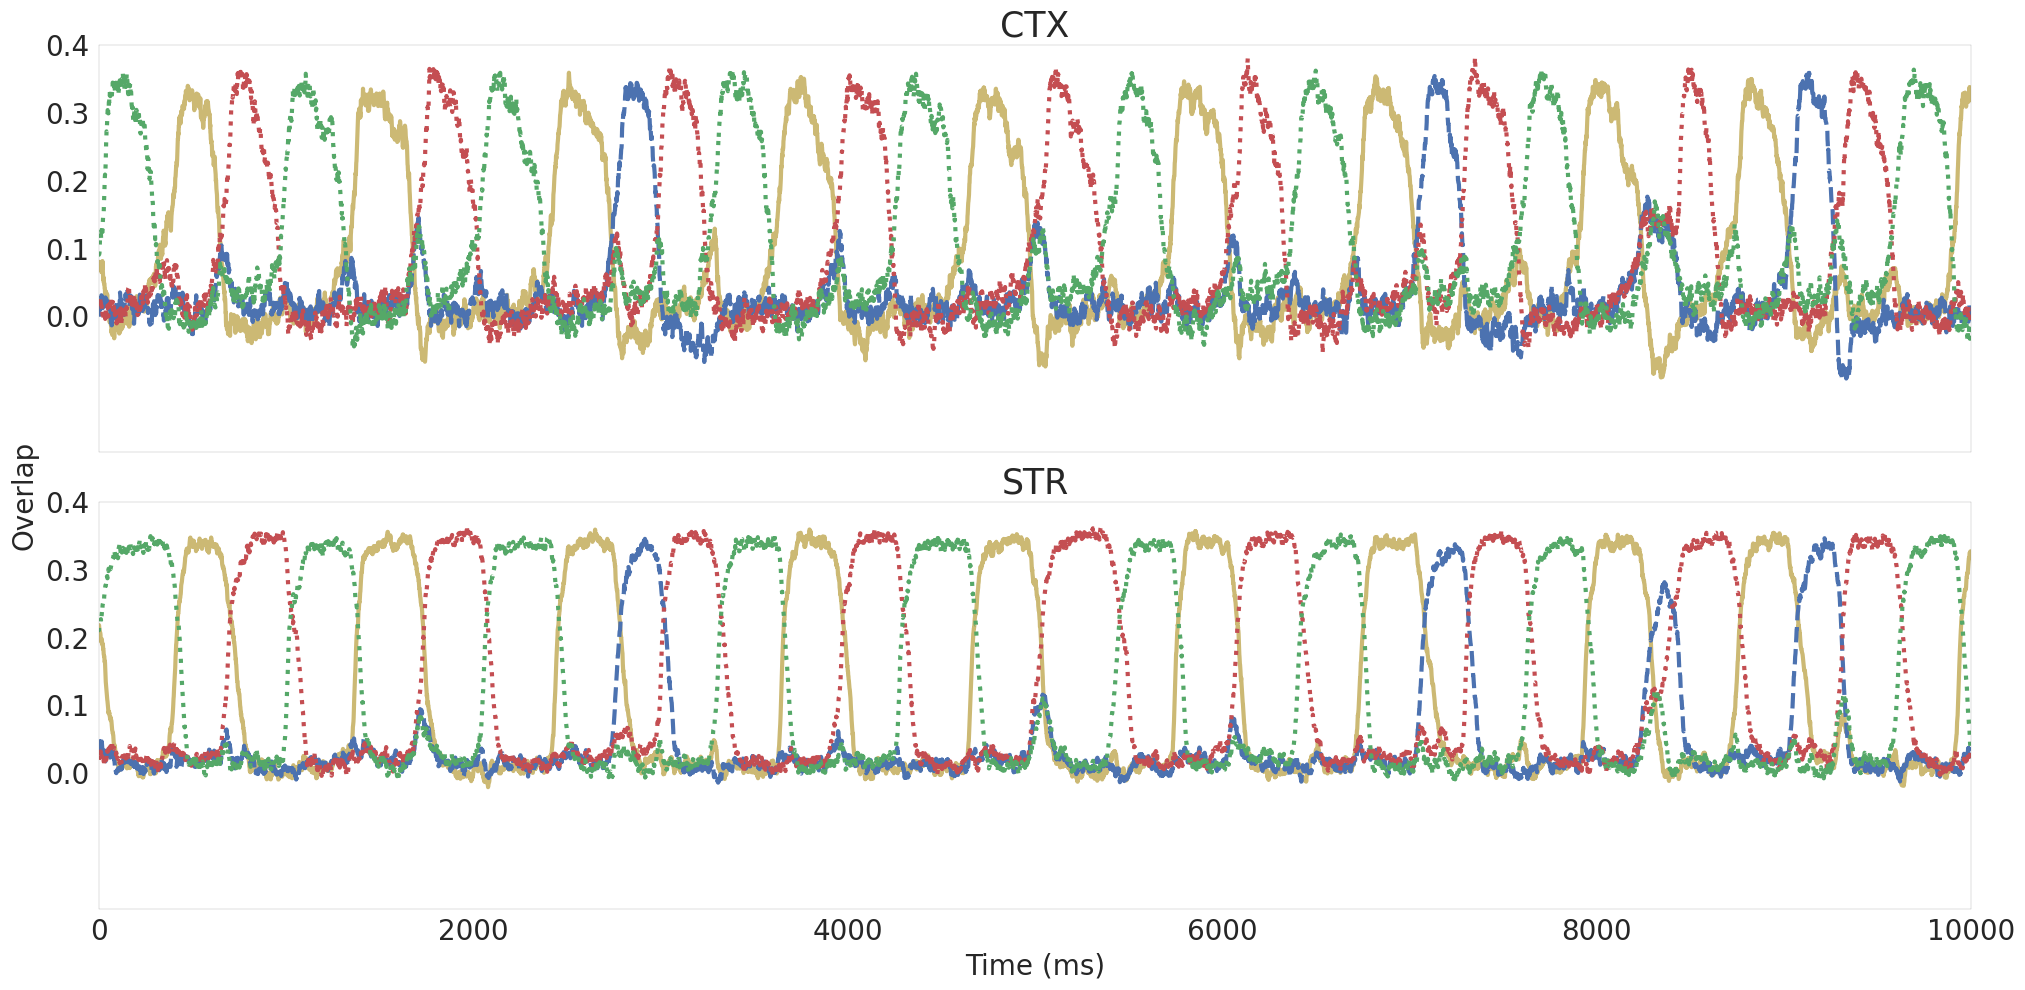

In [10]:
# Set font family globally
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(20,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
# axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
# axes.set_xlabel('Time (ms)', fontsize=20)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0, 10000))
plt.setp(axes, ylim=(-.2, .4))
# plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/simulation-online-learning-control.jpg', bbox_inches = "tight", format='jpg')

plt.show()


In [8]:
def temporal_diff(A, B, max_iter):
    sum = 0
    cnt = 0
    for i in range(len(A)):
        if i == 0: continue
        if B[i+1] == None:
            break
        diff = B[i+1][1] - A[i][1]
        sum += (diff)
        cnt += 1
    return sum / cnt

temporal_diff(mouse.behaviors[0], mouse.behaviors[1], 100)

356.73333333333335